In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('./EEG_data.csv')
data=pd.read_csv('./demographic_info.csv')

In [3]:
data = data.rename(columns = {'subject ID': 'SubjectID',' gender':'gender',' age':'age',' ethnicity':'ethnicity'})
df = df.merge(data,how = 'inner',on = 'SubjectID')

In [4]:
df.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln,age,ethnicity,gender
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0,25,Han Chinese,M
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0,25,Han Chinese,M
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0,25,Han Chinese,M
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0,25,Han Chinese,M
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0,25,Han Chinese,M


In [5]:
df['gender']=df['gender'].replace({'M':1,'F':0})
df['ethnicity']=df['ethnicity'].replace({'Han Chinese':0,'Bengali':1,'English':2})
df.drop(columns = ['SubjectID','VideoID','predefinedlabel'],inplace=True)

In [6]:
target=df['user-definedlabeln']

<Axes: title={'center': 'Correlation with Target'}>

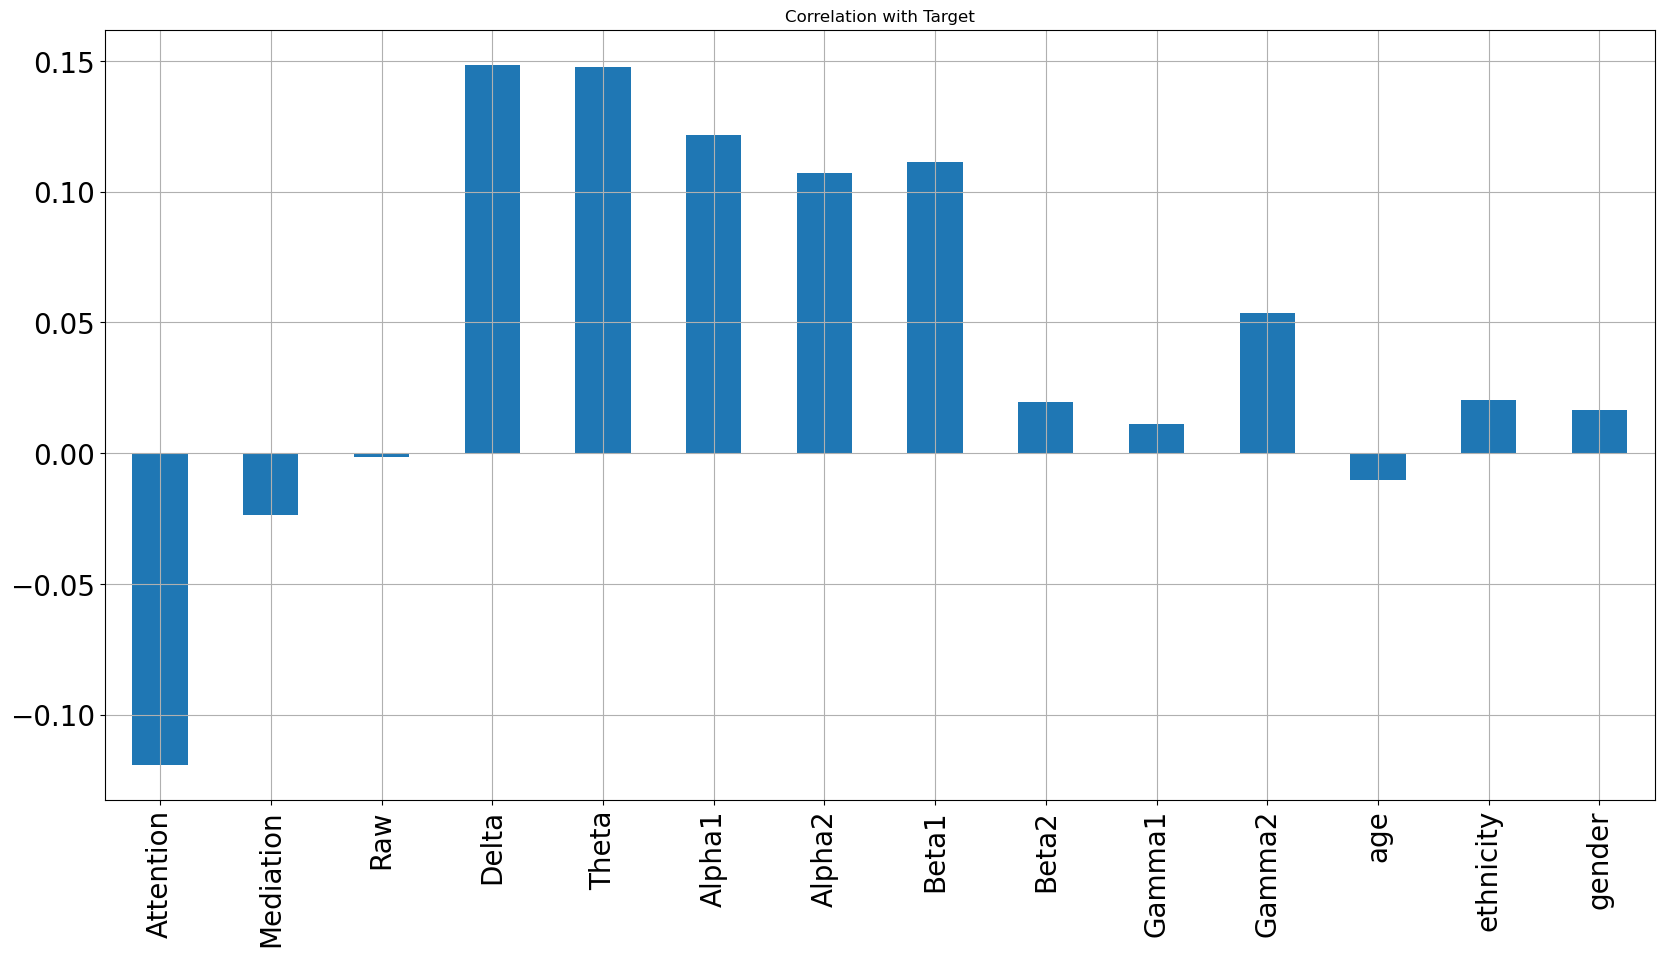

In [7]:
feature=df.drop(['user-definedlabeln'],axis=1)
feature.corrwith(df['user-definedlabeln']).plot.bar(
        figsize = (20, 10), title = "Correlation with Target", fontsize = 20,
        rot = 90, grid = True)

In [8]:
feature.shape

(12811, 14)

In [9]:
from sklearn.decomposition import TruncatedSVD

In [10]:
# Perform dimensionality reduction using TruncatedSVD
k = 3   # Choose the desired number of dimensions
svd = TruncatedSVD(n_components=k)
reduced_data = svd.fit_transform(feature)

# Create a DataFrame for visualization
columns = [f'PC{i+1}' for i in range(k)]
reduced_df = pd.DataFrame(reduced_data, columns=columns)

In [11]:
reduced_df

,PC1,PC2,PC3
0,3.206970e+05,26873.943035,34877.915035
1,7.862907e+04,9088.924942,-744.339634
2,8.480758e+05,226964.580969,51566.527410
3,1.985069e+06,-367061.755272,16642.203495
4,1.069594e+06,110571.244940,19141.367538
...,...,...,...
12806,1.287939e+05,-14966.281013,26040.702418
12807,5.462544e+05,778877.003086,237387.747015
12808,7.010354e+05,-13705.739053,-8492.168734
12809,3.622059e+05,-63372.713226,-809.068257


In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
scaler = StandardScaler()
X=scaler.fit_transform(reduced_data)

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
y=target
X_train,x_test,Y_train,y_test=train_test_split(X,y,random_state=108,test_size=0.27)

In [16]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [17]:
svm_classifier = SVC(random_state=108)

# Train the classifier on the training data
svm_classifier.fit(X_train, Y_train)

SVC(random_state=108)

In [18]:
predictions = svm_classifier.predict(x_test).astype(int)
predictions

array([0, 0, 1, ..., 0, 0, 0])

In [19]:
accuracy = accuracy_score(y_test, predictions)
accuracy

0.5964151488869616

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks,layers

2023-12-27 11:45:34.486779: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
inputs = tf.keras.Input(shape=(X_train.shape[1]))
x = tf.keras.layers.Dense(256, activation='relu')(inputs)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model=tf.keras.Model(inputs,outputs)
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy',tf.keras.metrics.AUC(name='auc')]
             )
batch_size=32
epochs=50
history=model.fit(
            X_train,
            Y_train,
            validation_split=0.2,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=[tf.keras.callbacks.ReduceLROnPlateau()]
)

2023-12-27 11:45:38.579364: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/50
234/234 [==============================] - 6s 22ms/step - loss: 0.6794 - accuracy: 0.5858 - auc: 0.6016 - val_loss: 0.6787 - val_accuracy: 0.5788 - val_auc: 0.6055 - lr: 0.0010
Epoch 2/50
234/234 [==============================] - 5s 23ms/step - loss: 0.6761 - accuracy: 0.5903 - auc: 0.6044 - val_loss: 0.6786 - val_accuracy: 0.5783 - val_auc: 0.6034 - lr: 0.0010
Epoch 3/50
234/234 [==============================] - 5s 21ms/step - loss: 0.6750 - accuracy: 0.5841 - auc: 0.6083 - val_loss: 0.6759 - val_accuracy: 0.5826 - val_auc: 0.6060 - lr: 0.0010
Epoch 4/50
234/234 [==============================] - 6s 25ms/step - loss: 0.6741 - accuracy: 0.5882 - auc: 0.6077 - val_loss: 0.6761 - val_accuracy: 0.5815 - val_auc: 0.6039 - lr: 0.0010
Epoch 5/50
234/234 [==============================] - 6s 26ms/step - loss: 0.6740 - accuracy: 0.5887 - auc: 0.6071 - val_loss: 0.6755 - val_accuracy: 0.5858 - val_auc: 0.6032 - lr: 0.0010
Epoch 6/50
234/234 [==============================] - 4s 17m

In [22]:
model.evaluate(x_test,y_test)

109/109 [==============================] - 1s 7ms/step - loss: 0.6686 - accuracy: 0.5958 - auc: 0.6255


[0.6686010956764221, 0.5958369374275208, 0.6255012154579163]

In [23]:
y_true = np.array(y_test)

y_pred = np.squeeze(model.predict(x_test))
y_pred = np.array(y_pred >=0.5, dtype=np.int)
y_pred

109/109 [==============================] - 1s 5ms/step


/tmp/ipykernel_7568/295032384.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = np.array(y_pred >=0.5, dtype=np.int)


array([0, 0, 1, ..., 0, 0, 0])

In [24]:
accuracyKeras=accuracy_score(y_true, y_pred)
accuracyKeras

0.5958369470945359